## Здравствуйте, меня зовут *Михаил Солоткий*, вот моё Задание №3 по курсу ПСАД-2019!

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from collections import defaultdict
from matplotlib import pyplot as plt
from statsmodels.tsa import adfvalues

import seaborn as sns
sns.set()

np.random.seed(228)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Задача 1  

Задана обучающая выборка $\widetilde{S}$, включающая значения переменных $X$ и $Y$.

In [2]:
from scipy.stats import linregress

def draw_linear(x, y, x_name='X', y_name='Y'):
    "Scatter x-y points and draw a LR line."
    slope, intercept, r, _, _ = linregress(x, y)
    x_max, x_min = x.max(), x.min()
    x_range = x_max - x_min
    x_lims = np.array([x_min - 0.1 * x_range, x_max + 0.1 * x_range])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(x, y, 'g+', label='Objects')
    plt.plot(x_lims, intercept + slope * x_lims, 'r--', label=r"LR line with $\rho \approx {:.3f}$".format(r))
    plt.legend()
    plt.show()

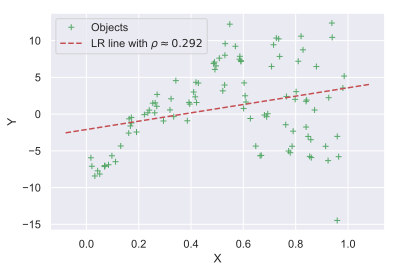

In [3]:
S = np.load("data1.npy")
X, Y = S
draw_linear(X, Y)

Оцените значимость коэффициента корреляции с помощью...

Критерия Стьюдента

In [4]:
def student_significance(X, Y):
    n = X.shape[0]
    _, _, r, _, _ = linregress(X, Y)
    t = r / np.sqrt(1 - r ** 2) * np.sqrt(n - 2)
    return 2 * stats.t.sf(t, n - 2)

Перестановочного теста

In [5]:
def permutation_test_significance(X, Y, n_permutations=10000):
    _, _, r_true, _, _ = linregress(X, Y)
    Y_copy = Y.copy()
    n_successes = 0
    for i in range(n_permutations):
        np.random.shuffle(Y_copy)
        _, _, r_fake, _, _ = linregress(X, Y_copy)
        if r_fake >= r_true:
            n_successes += 1
    return n_successes / n_permutations

Сравните результаты и сделайте выводы.

In [6]:
print("Student significance: ", round(student_significance(X, Y), 5))
print("PT significance: ", round(permutation_test_significance(X, Y), 5))

Student significance:  0.00324
PT significance:  0.0012


**Выводы:** Оба теста свидетельствуют об отсутствии линейной зависимости перменной Y от переменной X (на уровне значимости 0.05 или 0.005 к примеру), причём что интересно - перестановочный тест дал примерно в 2 раза меньший p-value, что намекает на то, что возможно ситуация, когда с помощью одного теста можно отвергнуть гипотезу, а с помощью второго - не получится отвергнуть.

### Задача 2


Сравните две группы $S_1$ и $S_2$ по переменным $X_1, \dots, X_{10}$ с использованием теста...

In [7]:
S1 = np.load("data2_1.npy")
S2 = np.load("data2_2.npy")

Манна-Уиттни

In [8]:
def mw_test(X_from_S1, X_from_S2):
    # https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
    X = np.concatenate((X_from_S1, X_from_S2))
    n_1 = X_from_S1.shape[0]
    n_2 = X_from_S2.shape[0]
    X_from_S1 = np.sort(X_from_S1)
    X_from_S2 = np.sort(X_from_S2)
    ranks_1 = np.empty(n_1)
    ranks_2 = np.empty(n_2)
    i = 0
    j = 0
    D = 0
    while i < n_1 and j < n_2:
        if X_from_S1[i] >= X_from_S2[j]:
            ranks_2[j] = i + j + 1
            j += 1
        elif X_from_S1[i] < X_from_S2[j]:
            ranks_1[i] = i + j + 1
            i += 1
    if i == n_1:
        ranks_2[j:] = np.arange(i + j + 1, n_1 + n_2 + 1)
    else:
        ranks_1[i:] = np.arange(i + j + 1, n_1 + n_2 + 1)
    U_1 = ranks_1.sum() - n_1 * (n_1 + 1) / 2
    U_2 = ranks_2.sum() - n_2 * (n_2 + 1) / 2
    T = min(U_1, U_2)
    mu = n_1 * n_2 / 2
    sigma = np.sqrt(n_1 * n_2 * (n_1 + n_2 + 1) / 12)
    cdf = stats.norm.cdf(T, loc=mu, scale=sigma)
    return 2 * min(cdf, 1 - cdf)

Колмогорова-Смирнова

In [9]:
def ks_test(X_from_S1, X_from_S2):
    # https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    X_from_S1 = np.sort(X_from_S1)
    X_from_S2 = np.sort(X_from_S2)
    n_1 = X_from_S1.shape[0]
    n_2 = X_from_S2.shape[0]
    i = 0
    j = 0
    D = 0
    while i < n_1 and j < n_2:
        if X_from_S1[i] > X_from_S2[j]:
            j += 1
        elif X_from_S1[i] < X_from_S2[j]:
            i += 1
        else:
            i += 1
            j += 1
        if np.abs(i / n_1 - j / n_2) > D:
            D = np.abs(i / n_1 - j / n_2)
    if i == n_1 and 1 - j / n_2 > D:
        D = 1 - j / n_2
    if j == n_2 and 1 - i / n_1 > D:
        D = 1 - i / n_1
    return np.exp(-2 * D ** 2 * n_1 * n_2 / (n_1 + n_2))

In [10]:
res = defaultdict(list)

for i, (X_from_S1, X_from_S2) in enumerate(zip(S1, S2)):
    res["X"].append(i+1)
    res["Mann–Whitney"].append(mw_test(X_from_S1, X_from_S2))
    res["Kolmogorov–Smirnov"].append(ks_test(X_from_S1, X_from_S2))

pd.DataFrame(res)

,X,Mann–Whitney,Kolmogorov–Smirnov
0,1,6.900047e-03,3.995846e-03
1,2,8.468941e-01,7.389685e-01
2,3,3.952950e-01,2.981973e-01
3,4,2.520686e-01,1.053151e-21
4,5,7.018682e-01,1.208182e-19
5,6,8.149181e-01,6.228913e-20
6,7,9.699321e-06,2.226299e-04
7,8,2.238523e-07,3.363596e-06
8,9,1.129567e-03,5.041760e-03
9,10,4.318082e-01,5.041760e-03


Выясните, какие переменные являются значимыми на уровне $\alpha$ с учётом коррекции...

In [11]:
alpha = 0.05

Бонферрони

In [12]:
def bonferroni_corr(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    return np.array(p_vals) * len(p_vals) < alpha

Бонферрони-Холма

In [13]:
def bh_corr(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    # Your code goes here...
    p_vals = np.array(p_vals)
    n = len(p_vals)
    argsrt = np.argsort(p_vals)
    inv_argsrt = np.argsort(argsrt)
    res = p_vals[argsrt] < alpha / (n + 1 - np.arange(1, n + 1))
    return res[inv_argsrt]

Сравните результаты и сделайте выводы.

In [14]:
res_corr = defaultdict(list)
res_corr["X"] = res["X"]
res_corr["MW rejected w/ Bonferroni"] = bonferroni_corr(res["Mann–Whitney"])
res_corr["MW rejected w/ BH"] = bh_corr(res["Mann–Whitney"])
res_corr["KS rejected w/ Bonferroni"] = bonferroni_corr(res["Kolmogorov–Smirnov"])
res_corr["KS rejected w/ BH"] = bh_corr(res["Kolmogorov–Smirnov"])
pd.DataFrame(res_corr)

,X,MW rejected w/ Bonferroni,MW rejected w/ BH,KS rejected w/ Bonferroni,KS rejected w/ BH
0,1,False,True,True,True
1,2,False,False,False,False
2,3,False,False,False,False
3,4,False,False,True,True
4,5,False,False,True,True
5,6,False,False,True,True
6,7,True,True,True,True
7,8,True,True,True,True
8,9,True,True,False,True
9,10,False,False,False,True


*Дополнительная информация:* на самом деле лишь переменные $X_1$, $X_2$ и $X_3$ имеют одинаковое распределение.

**Выводы:** Тесты не идеально отражают реальную картину. Для пар величин ($X_1$, $X_2$), ($X_2$, $X_3$) все тесты верно подтверждают нулевую гипотезу о равенстве распределений, но к сожалению, она подтверждается ещё и в случаях, когда распределения разные, что говорит о том, что поправки Бонферрони и Бонферрони-Холма недостаточно точны, если бы они были более точными, возможно, в ситуациях, когда гипотеза была ошибочно принята, p-value был бы ниже и соответствующая гипотеза была бы уже отвергнута.

### Задача 3

Найдите линейный временной тренд в предоставленном временном ряду $X_t$.

In [15]:
def plot_ts(X_t, title):
    plt.plot(X_t)
    plt.title(title)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$X_t$")
    plt.show()

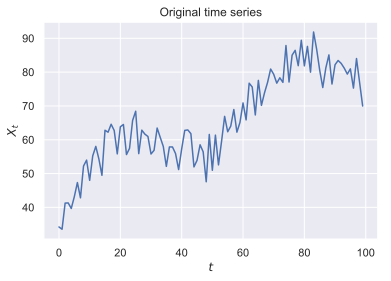

In [16]:
X_t = np.load("data3.npy")
plot_ts(X_t, "Original time series")

In [17]:
def linear_trend(X_t):
    "Must return floats a, b: LinTrend(X_t) = a * t + b"
    n = X_t.shape[0]
    slope, intercept, _, _, _ = linregress(np.arange(n), X_t)
    return slope, intercept

In [18]:
print("Linear trend: X_t ~ a * t + b")
a, b = linear_trend(X_t)
print("a = ", round(a, 3))
print("b = ", round(b, 3))

Linear trend: X_t ~ a * t + b
a =  0.401
b =  45.718


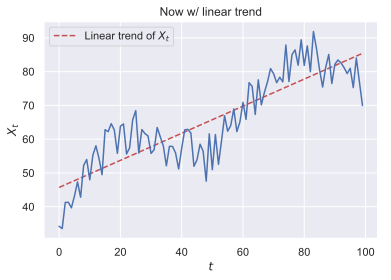

In [19]:
t = np.arange(len(X_t))
plt.plot(t, b + a * t, 'r--', label=r"Linear trend of $X_t$")
plt.legend()
plot_ts(X_t, "Now w/ linear trend")

После вычитания тренда проведите проверку на стохастическую нестационарность с помощью теста Дикки-Фуллера.

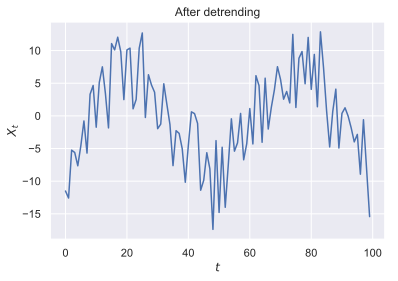

In [20]:
X_t_detrended = X_t - b - a * np.arange(len(X_t))
plot_ts(X_t_detrended, "After detrending")

In [23]:
def dfuller(X_t_detrended):
    "Must return p-value"
    # formulas from OV's lections
    y = X_t_detrended[1:] - X_t_detrended[:-1]
    x = X_t_detrended[:-1]
    beta, shift, _, _, _ = linregress(x, y)
    y_pred = x * beta + shift
    sigma_err = np.sqrt(((y - y_pred) ** 2).sum() / (len(y) - 2))
    sigma = sigma_err / np.sqrt(((x - x.mean()) ** 2).sum())
    T = beta / sigma
    print('using t-test, p-value is', stats.t.cdf(T, len(y) - 2))
    p_value = adfvalues.mackinnonp(T)
    print("using Dickey–Fuller's distribution, p-value is", p_value)
    return p_value

In [24]:
print("Detrended X_t is nonstationary with {} probability.".format(dfuller(X_t_detrended)))

using t-test, p-value is 2.066663479271081e-06
using Dickey–Fuller's distribution, p-value is 3.78416459869068e-05
Detrended X_t is nonstationary with 3.78416459869068e-05 probability.


Не забудьте сделать выводы!

**Выводы:** реализация процесса не похожа на то, что можно наблюдать при случайном блуждании, кривая явно зависит от врмени (причём даже на зашумлённый синус похож). Но в тесте Дикки-Фулера не совсем нестационарность отвергает, скорее нестационарность, объяснённая случайным блужданием. Тут ещё в шаблонном коде говорится про вероятность того, что процесс нестационарный, это не совсем правильная интерпретация p-value, всё-таки в проверке гипотез мы можем получить вероятность при условии какой-то гипотезы, но не безусловную вероятность (вот тут подробнее об этом https://www.coursera.org/lecture/stats-for-data-analysis/dostighaiemyi-urovien-znachimosti-0NLz9). Кстати, p_value около $10^{-78}$ - как-то слишком жёстко.